In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from workalendar.asia import SouthKorea 

# statsmodel 확인
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from torch.utils.data import DataLoader, TensorDataset

# 오류 무시하는 방법
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/home/dlwhdtmd/zongseung/EDA/demand_celcius.csv")
df = df.set_index("일시")
df = df.drop("Unnamed: 0", axis=1)
df.index = pd.to_datetime(df.index)

### 독립변수 추가

In [3]:
import datetime as dt
cal = SouthKorea()

def holiday_weekday(data):
    holiday_data = []

    for date in data.index:

        if date.weekday() in [5, 6] or cal.is_holiday(date) is True:  # 주말 (토요일=5, 일요일=6) / 공휴일까지 포함시켜서 확인한다.
            holiday_data.append(2) # 2번은 쉬는날
        else:  # 그 외 날짜 
            holiday_data.append(1) # 안쉬는날

    data["holiday_data"] = holiday_data    
    
    return data

def get_season_by_month(month):
    asd = []
    
    for i in month: 
        if 3 <= i <= 5: 
            asd.append(1) # 봄
        elif 6 <= i <= 8:
            asd.append(2) # 여름
        elif 9 <= i <= 11:
            asd.append(3)
        else:
            asd.append(4)
    return asd

In [4]:
df["month"] = df.index.month

df_holiday = holiday_weekday(df)
df_holiday["season"] = get_season_by_month(df_holiday["month"])

In [5]:
# 더미 변수 생성 알고리즘
def select_date(data):

        dummies = pd.get_dummies(data["holiday_data"]).astype("int")
        season_dummies = pd.get_dummies(data["season"]).astype("int")
        
        data = pd.concat([data, dummies], axis = 1)
        data.drop(["holiday_data", "season"], axis=1, inplace=True)

        data.rename(columns = {1:"weekday",
        2:"weekend"}, inplace=True)

        data = pd.concat([data, season_dummies], axis = 1)

        data.rename(columns = {1:"spring",
        2:"summer",
        3:"autoum",
        4:"winter"}, inplace=True)
        
        return data

In [6]:
import datetime as dt
df.reset_index(inplace=True)
# 연,월,일 생성
df["ymd"] = df["일시"].dt.strftime('%Y-%m-%d')

# 더미 변수 생성
df = select_date(df)

In [7]:
df.set_index("일시", inplace=True)

In [8]:
df["date"] = df[["weekday", "weekend"]].idxmax(axis=1)

plt.figure(figsize=(20,10))
sns.scatterplot(x= df[:31*24].index,y=df["power demand(MW)"][:31*24], hue=df["date"][:31*24])
plt.title("2019 jan demand data")

NameError: name 'sns' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
df

,hm,ta,power demand(MW),month,ymd,weekday,weekend,spring,summer,autoum,winter,date
일시,,,,,,,,,,,,
2019-01-01 00:00:00,59.705026,-4.174162,65388.0,1,2019-01-01,0,1,0,0,0,1,weekend
2019-01-01 01:00:00,60.096649,-4.349947,63045.0,1,2019-01-01,0,1,0,0,0,1,weekend
2019-01-01 02:00:00,61.854850,-4.491993,61036.0,1,2019-01-01,0,1,0,0,0,1,weekend
2019-01-01 03:00:00,63.020635,-4.648325,59834.0,1,2019-01-01,0,1,0,0,0,1,weekend
2019-01-01 04:00:00,63.784303,-4.722354,59491.0,1,2019-01-01,0,1,0,0,0,1,weekend
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,75.547619,15.667637,67551.0,10,2024-10-31,1,0,0,0,1,0,weekday
2024-10-31 20:00:00,79.587125,14.787954,65341.0,10,2024-10-31,1,0,0,0,1,0,weekday
2024-10-31 21:00:00,82.265079,14.053263,63341.0,10,2024-10-31,1,0,0,0,1,0,weekday


NameError: name 'sns' is not defined

<Figure size 2000x1000 with 0 Axes>

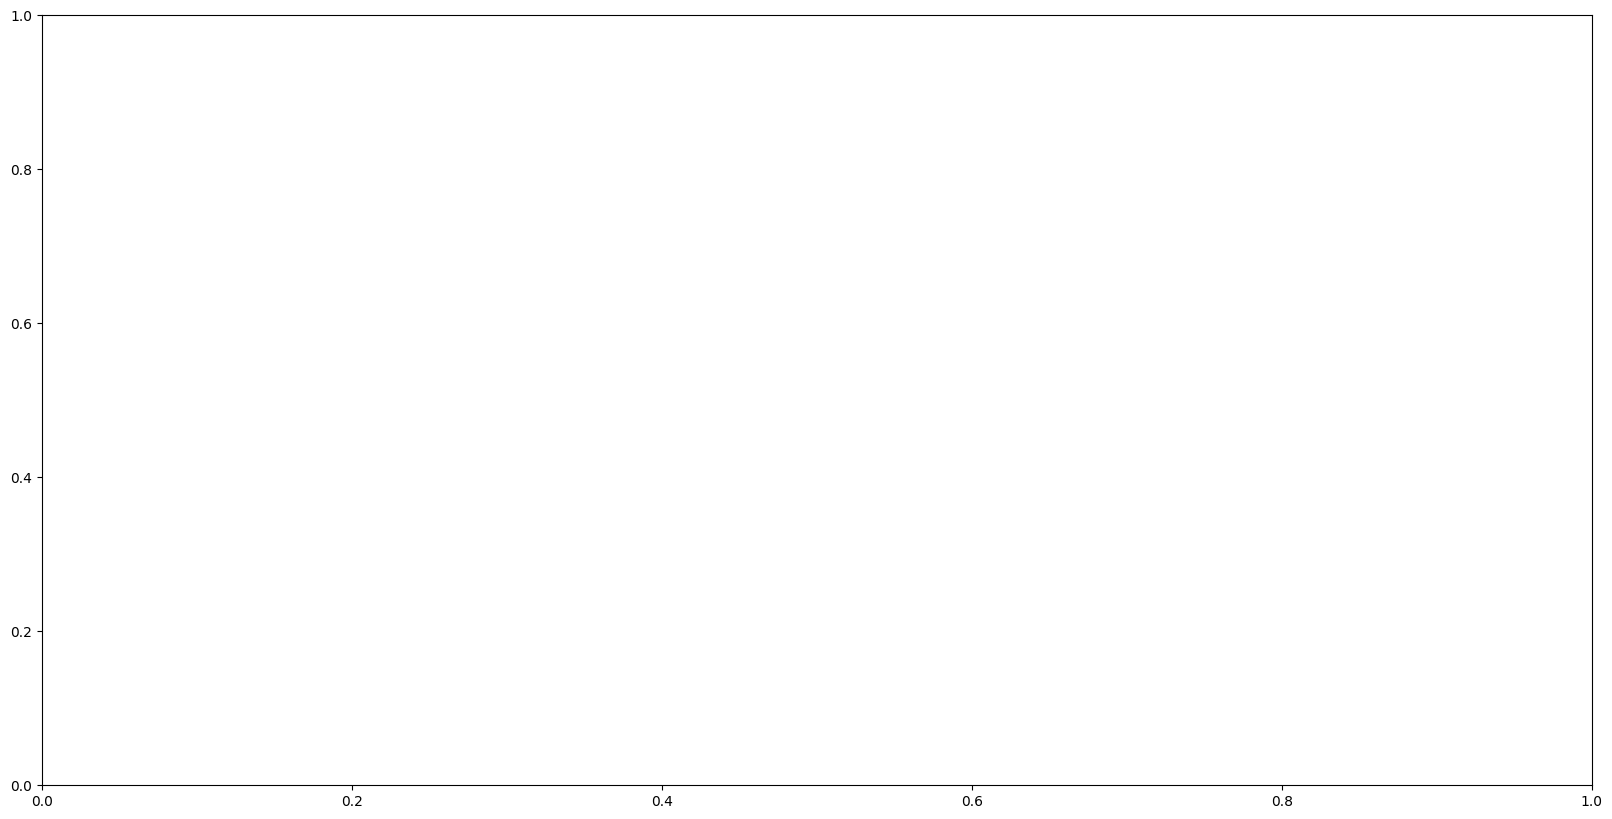

In [9]:
# 그래프 크기 설정
plt.figure(figsize=(20, 10))

# 첫 번째 축 (power demand)
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.scatterplot(x=df.index, y=df["power demand(MW)"], ax=ax1, color="blue", label="Power Demand (MW)")
ax1.set_ylabel("Power Demand (MW)", color="green")
ax1.tick_params(axis='y', labelcolor="green")

# 두 번째 축 (ta) - hue 사용
ax2 = ax1.twinx()
sns.scatterplot(x=df.index, y=df["ta"], ax=ax2, hue=df["season"], palette="viridis")
ax2.set_ylabel("Temperature (ta)", color="black")
ax2.tick_params(axis='y', labelcolor="black")

# 공통 x축 라벨 설정
ax1.set_xlabel("Index")

# 그래프 제목 설정
plt.title("Power Demand vs Temperature")

# 범례 조정 (seaborn의 hue 범례만 유지)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles=handles2, labels=labels2, loc="upper left")

# 그래프 표시
plt.show()

In [10]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.scatterplot( x=df.index, y=df["power demand(MW)"], hue=df["season"])

KeyError: 'season'

<Figure size 2000x1000 with 0 Axes>

In [11]:
# hm	ta	power demand(MW) weekday	weekend	spring	summer	autoum	winter
df.reset_index(inplace=True)
df1 = df.groupby("일시")[["hm",	"ta", "power demand(MW)", "weekday", "weekend",	"spring", "summer",	"autoum", "winter"]].mean()

# 외생변수의 표준화 실시
from sklearn.preprocessing import MinMaxScaler
mn = MinMaxScaler()

In [12]:
df.set_index("일시", inplace=True)

df.index = pd.to_datetime(df.index)
df.index = df.index.to_period("H").to_timestamp()

In [13]:
# 이후 코드로 변수를 1시간 단위 데이터로 쪼개고 접근하기
train_data = df[df.index<="2022-01-01"]
test_data = df[df.index>"2022-01-01"]

# 표준화
train_data[["hm", "ta","weekday", "weekend",	"spring", "summer",	"autoum", "winter"]] = mn.fit_transform(train_data[["hm",
                                                                                                                      "ta","weekday", "weekend",	"spring", "summer",	"autoum", "winter"]])
test_data[["hm", "ta","weekday", "weekend",	"spring", "summer",	"autoum", "winter"]] = mn.transform(test_data[["hm",	
                                                                                                               "ta","weekday", "weekend",	"spring", "summer",	"autoum", "winter"]])

### SARAIMAX 적용

In [14]:
test_data_sample = test_data[test_data.index>="2024-01-01"]
test_data_sample

,hm,ta,power demand(MW),month,ymd,weekday,weekend,spring,summer,autoum,winter,date
일시,,,,,,,,,,,,
2024-01-01 00:00:00,0.889666,0.372369,59440.0,1,2024-01-01,0.0,1.0,0.0,0.0,0.0,1.0,weekend
2024-01-01 01:00:00,0.902763,0.367275,56989.0,1,2024-01-01,0.0,1.0,0.0,0.0,0.0,1.0,weekend
2024-01-01 02:00:00,0.914576,0.360940,55335.0,1,2024-01-01,0.0,1.0,0.0,0.0,0.0,1.0,weekend
2024-01-01 03:00:00,0.926929,0.354773,54477.0,1,2024-01-01,0.0,1.0,0.0,0.0,0.0,1.0,weekend
2024-01-01 04:00:00,0.942791,0.348573,54522.0,1,2024-01-01,0.0,1.0,0.0,0.0,0.0,1.0,weekend
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,0.734088,0.643756,67551.0,10,2024-10-31,1.0,0.0,0.0,0.0,1.0,0.0,weekday
2024-10-31 20:00:00,0.783040,0.626396,65341.0,10,2024-10-31,1.0,0.0,0.0,0.0,1.0,0.0,weekday
2024-10-31 21:00:00,0.815492,0.611897,63341.0,10,2024-10-31,1.0,0.0,0.0,0.0,1.0,0.0,weekday


In [ ]:
pmd_7 = auto_arima(train_data["power demand(MW)"], exog = train_data.drop(["power demand(MW)",	"month","ymd"], axis=1),
                   d=1,
                   max_p = 4,
                   max_q = 3,
                   m=24, 
                   max_order=8, trace=True)

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [31]:
model = SARIMAX(train_data["power demand(MW)"], 
                 exog = train_data.drop(["power demand(MW)", "month", "ymd"], axis=1), order = (2,1,2), seasonal_order=(2,0,1,24))
model_fit = model.fit()

model_fit.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45424D+00    |proj g|=  2.40596D-02

At iterate    5    f=  8.44623D+00    |proj g|=  8.03070D-03

At iterate   10    f=  8.42364D+00    |proj g|=  1.57418D-02

At iterate   15    f=  8.41887D+00    |proj g|=  9.44042D-03

At iterate   20    f=  8.41775D+00    |proj g|=  6.28651D-03

At iterate   25    f=  8.41752D+00    |proj g|=  6.14407D-04

At iterate   30    f=  8.41721D+00    |proj g|=  6.57779D-03

At iterate   35    f=  8.37431D+00    |proj g|=  5.91060D-02

At iterate   40    f=  8.35351D+00    |proj g|=  1.11834D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     power demand(MW)   No. Observations:                26305
Model:             SARIMAX(2, 1, 2)x(2, 0, [1], 24)   Log Likelihood             -219707.911
Date:                              Mon, 30 Dec 2024   AIC                         439447.822
Time:                                      06:57:51   BIC                         439578.662
Sample:                                  01-01-2019   HQIC                        439490.068
                                       - 01-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hm           -74.0780      0.010  -7321.546      0.000     -74.098     -74.058
ta          1.587e+04   4.74e-05   3.34e+08      0.000    1.59e+04    1.59e+04
weekday      134.0174      0.006    2.4e+04      0.000     134.006     134.028
weekend     -133.8757      0.006  -2.39e+04      0.000    -133.887    -133.865
spring        73.0433      0.010   7118.753      0.000      73.023      73.063
summer       132.2287      0.006   2.33e+04      0.000     132.218     132.240
autoum       -78.6974      0.010  -8263.494      0.000     -78.716     -78.679
winter      -126.4329      0.006  -2.13e+04      0.000    -126.445    -126.421
ar.L1          1.3554      0.000   3759.169      0.000       1.355       1.356
ar.L2         -0.5174      0.000  -4495.501      0.000      -0.518      -0.517
ma.L1         -0.5898      0.000  -2525.095      0.000      -0.590      -0.589
ma.L2         -0.0597   3.21e-05  -1857.846      0.000      -0.060      -0.060
ar.S.L24       1.3638   4.92e-05   2.77e+04      0.000       1.364       1.364
ar.S.L48      -0.3638   4.89e-05  -7446.772      0.000      -0.364      -0.364
ma.S.L24      -0.9660      0.000  -2246.358      0.000      -0.967      -0.965
sigma2      2.092e+06   2.58e-07   8.11e+12      0.000    2.09e+06    2.09e+06
===================================================================================
Ljung-Box (L1) (Q):                  51.11   Jarque-Bera (JB):          40099372.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                       194.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.34e+26. Standard errors may be unstable.
"""

In [16]:
import time 

# 1시간 단위로 패턴 파악
history = [x for x in train_data["power demand(MW)"]]
predictions = []

# 진행 상황 출력용 변수
start_time = time.time()

# walk-forward validation
n_periods = 24  # 한 번에 예측할 스텝
for i in range(0, len(test_data), n_periods):
    # step 크기 계산
    step = min(n_periods, len(test_data) - i)

    exog_data = test_data.drop(["power demand(MW)",	"month","ymd"], axis=1).iloc[i:i+step]

    # 여러 스텝 예측
    fc = model_fit.get_forecast(steps=step, exog=exog_data).predicted_mean
    predictions.extend(fc)

    # 상태 업데이트
    new_endog = test_data["power demand(MW)"].iloc[i:i+step]
    new_exog = exog_data
    model_fit = model_fit.append(endog=new_endog, exog=new_exog)

    # 진행 상황 출력 (100회마다)
    if (i // n_periods + 1) % 100 == 0:  # 100번째 예측 단위마다 출력
        elapsed_time = time.time() - start_time
        print(f"Processed {i + step}/{len(test_data)} steps in {elapsed_time:.2f} seconds")

# 최종 결과 출력
print("Processing complete!")

NameError: name 'model_fit' is not defined

In [15]:
# 예측값 저장
predictions = pd.read_csv("/home/dlwhdtmd/zongseung/1_hour_pred.csv")

r2_score : 0.6881738239454865
mean_squared_error : 5789.15447641252
mean_absolute_percentage_error:0.06051528460789004


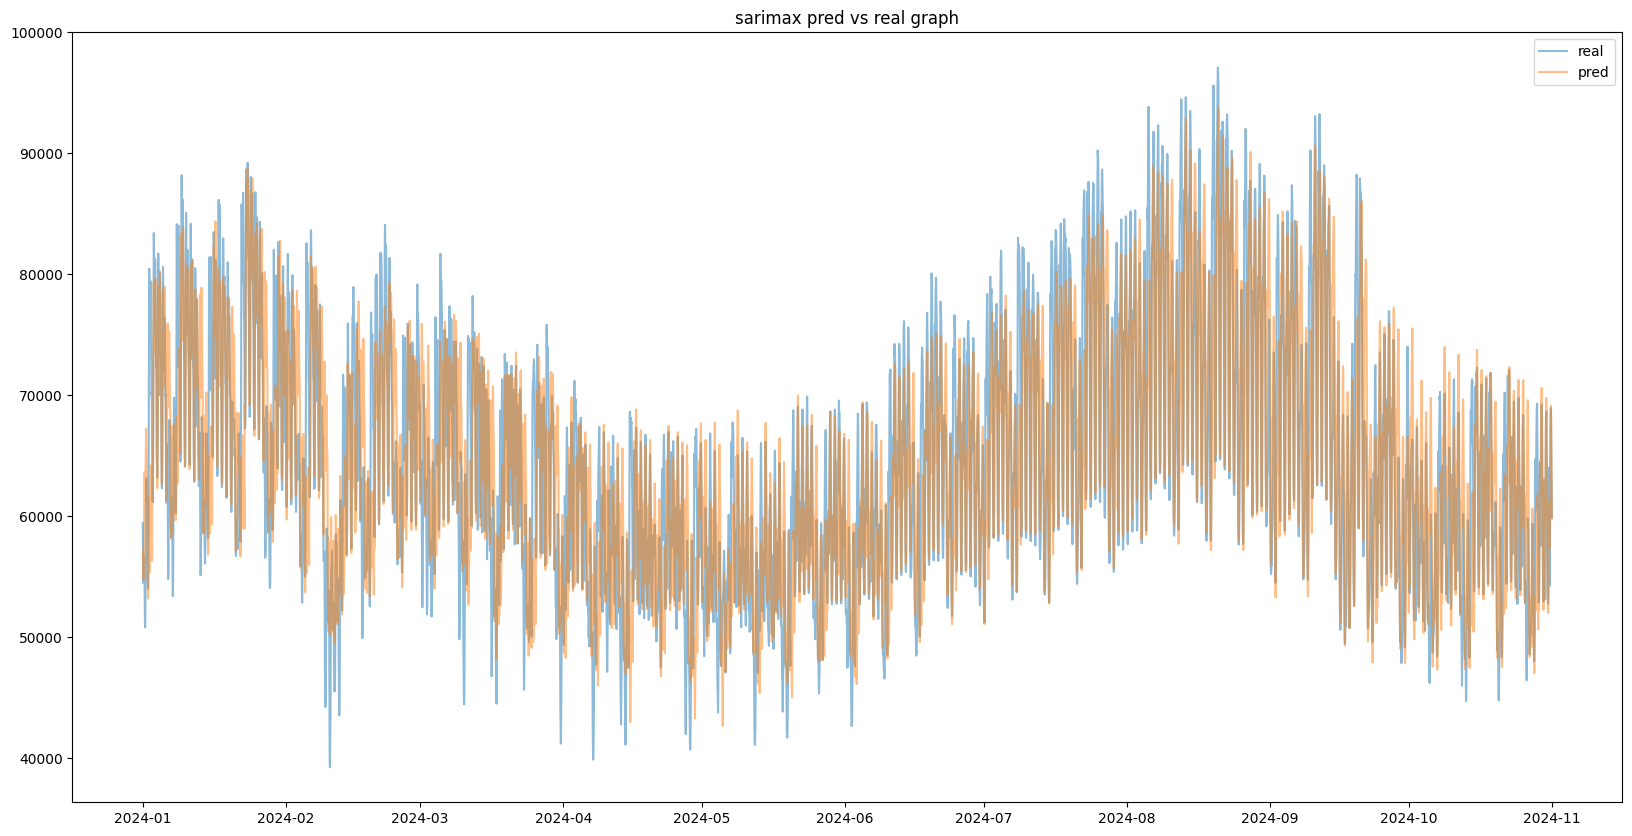

In [16]:
# test 셋에 대한 잔차 생성
residual_test = test_data["power demand(MW)"][-24*305:].values - predictions["0"][-24*305:]

# 
plt.figure(figsize=(20,10))
plt.plot(test_data_sample.index, test_data["power demand(MW)"].values[-24*305:], alpha=0.5, label = "real")
plt.plot(test_data_sample.index, predictions["0"][-24*305:].values, label = "pred", alpha=0.5)
plt.title("sarimax pred vs real graph")
plt.legend()

# SARIMAX 평가지표 확인
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error 
test = test_data["power demand(MW)"].values[-24*305:]
ssss = predictions[-24*305:]["0"].values

print(f"r2_score : {r2_score(test, ssss)}")
print(f"mean_squared_error : {root_mean_squared_error(test, ssss)}")
print(f"mean_absolute_percentage_error:{mean_absolute_percentage_error(test, ssss)}")

### sarimax-lstm 작업시작

In [17]:
residual = test_data["power demand(MW)"][:].values - predictions["0"][:]

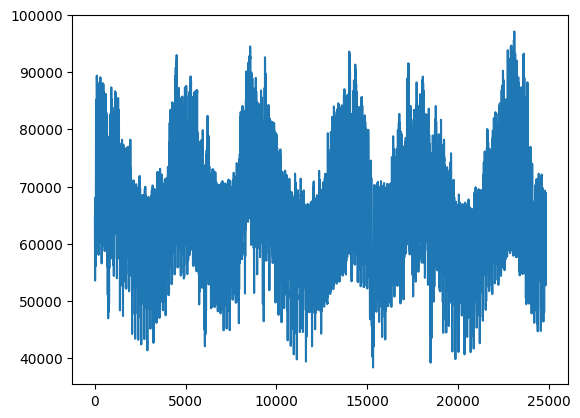

In [18]:
test_data1 = test_data.reset_index()
plt.plot(test_data1["power demand(MW)"])

In [19]:
pred_pred = pd.read_csv("/home/dlwhdtmd/zongseung/1_hour_pred.csv") # sarimax의 예측값

In [20]:
# 데이터 길이
total_data_length = len(residual)  # residual 총 길이
test_size = 305 * 24  # 7320
val_fraction = 0.3  # 검증 데이터 비율

# 데이터 분리 크기 계산
train_val_length = total_data_length - test_size
train_length = int(train_val_length * (1 - val_fraction))
val_length = train_val_length - train_length

# 데이터 분리
residual_train = residual[:train_length]
residual_val = residual[train_length:train_length + val_length]
residual_test = residual[train_length + val_length:]

# 데이터 병합
residual_train_data = pd.concat([residual_train, test_data1[["hm", "ta", "weekday", "weekend", "spring", "summer", "autoum", "winter"]][:train_length]], axis=1)
residual_val_data = pd.concat([residual_val, test_data1[["hm", "ta", "weekday", "weekend", "spring", "summer", "autoum", "winter"]][train_length:train_length + val_length]], axis=1)
residual_test_data = pd.concat([residual_test, test_data1[["hm", "ta", "weekday", "weekend", "spring", "summer", "autoum", "winter"]][train_length + val_length:]], axis=1)

# 스케일링
mnx = MinMaxScaler()
mny = MinMaxScaler()

residual_train_x = mnx.fit_transform(residual_train_data[["hm", "ta", "weekday", "weekend", "spring", "summer", "autoum", "winter"]])
residual_train_y = mny.fit_transform(residual_train_data["0"].values.reshape(-1, 1))

residual_val_x = mnx.transform(residual_val_data[["hm", "ta", "weekday", "weekend", "spring", "summer", "autoum", "winter"]])
residual_val_y = mny.transform(residual_val_data["0"].values.reshape(-1, 1))

residual_test_x = mnx.transform(residual_test_data[["hm", "ta", "weekday", "weekend", "spring", "summer", "autoum", "winter"]])
residual_test_y = mny.transform(residual_test_data["0"].values.reshape(-1, 1))

In [21]:
print(residual_train_x.shape)
print(residual_val_x.shape)
print(residual_test_x.shape)

(12263, 8)
(5256, 8)
(7320, 8)


#### 0:24 -> 25 슬라이딩 윈도우

In [22]:
def sliding_window(input_data, target_data, window_size):
    x = []
    y = []
    
    for i in range(len(input_data) - window_size):
        xx = input_data[i:window_size + i]  # 윈도우 크기 만큼 입력 생성
        yy = target_data[window_size + i -1]  # 윈도우의 마지막 값을 출력으로 설정
        x.append(xx)
        y.append(yy)
    
    return np.array(x), np.array(y)

In [23]:
train_x, train_y = sliding_window(residual_train_x, residual_train_y, window_size=24)
val_x, val_y = sliding_window(residual_val_x, residual_val_y, window_size=24)
test_x, test_y = sliding_window(residual_test_x, residual_test_y, window_size=24)
train_x, train_y, test_x, test_y


# 변수 shape 확인
print(f"train_x shape{train_x.shape}")
print(f"train_x shape{train_y.shape}")
print(f"val_x shape{val_x.shape}")
print(f"val_y shape{val_y.shape}")
print(f"test_x shape{test_x.shape}")
print(f"test_y shape{test_y.shape}")

train_x shape(12239, 24, 8)
train_x shape(12239, 1)
val_x shape(5232, 24, 8)
val_y shape(5232, 1)
test_x shape(7296, 24, 8)
test_y shape(7296, 1)


#### 24:48-> 24 t슬라이딩

### CNN-LSTM

In [25]:
# LSTM 모델 정의
class LSTM_CNN1D(nn.Module):
    def __init__(self, lstm_layers, dense_layers, units, dense_units, lstm_dropout_rate, 
                 dense_dropout_rate, input_features, cnn_filters=64, kernel_size=3):
        super(LSTM_CNN1D, self).__init__()
        
        # 1D CNN 레이어
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_features, out_channels=cnn_filters, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_filters),
            nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_filters)
        )
        
        # LSTM 레이어
        self.lstm = nn.LSTM(
            input_size=cnn_filters,  # CNN의 출력 채널 수가 LSTM의 입력이 됨
            hidden_size=units, 
            num_layers=lstm_layers, 
            dropout=lstm_dropout_rate, 
            batch_first=True
        )
        
        # Dense 레이어
        self.dense_layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(units if i == 0 else dense_units, dense_units),
                nn.ReLU(),
                nn.Dropout(dense_dropout_rate)
            ) for i in range(dense_layers)]
        )
        
        # 출력 레이어
        self.output_layer = nn.Linear(dense_units if dense_layers > 0 else units, 1)
        
    def forward(self, x):
        # 입력 형태 변환 (batch, sequence, features) -> (batch, features, sequence)
        x = x.transpose(1, 2)
        
        # CNN 적용
        x = self.cnn(x)
        
        # LSTM을 위한 형태 변환 (batch, features, sequence) -> (batch, sequence, features)
        x = x.transpose(1, 2)
        
        # LSTM 적용
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 마지막 타임스텝 출력 사용
        
        # Dense 레이어 적용
        for layer in self.dense_layers:
            x = layer(x)
            
        # 출력 레이어
        x = self.output_layer(x)
        return x
# DataLoader 생성 함수
def create_dataloader(X, Y, batch_size):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 64)
    return dataloader

# Fitness 함수
def fitness_function(params, X_train, Y_train, X_val, Y_val, device):
    # 파라미터 확장
    (lstm_layers, dense_layers, units, dense_units, learning_rate, 
     lstm_dropout_rate, dense_dropout_rate, batch_size, 
     cnn_filters, kernel_size) = (
        int(params[0]), int(params[1]), int(params[2]), int(params[3]), 
        params[4], params[5], params[6], int(params[7]),
        int(params[8]), int(params[9])
    )

    # LSTM_CNN1D 모델 생성
    input_features = X_train.shape[2]
    model = LSTM_CNN1D(
        lstm_layers=lstm_layers,
        dense_layers=dense_layers,
        units=units,
        dense_units=dense_units,
        lstm_dropout_rate=lstm_dropout_rate,
        dense_dropout_rate=dense_dropout_rate,
        input_features=input_features,
        cnn_filters=cnn_filters,
        kernel_size=kernel_size
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # DataLoader 생성
    train_loader = create_dataloader(X_train, Y_train, batch_size)

    # 모델 학습
    model.train()
    for epoch in range(50):  # 간단히 50 Epoch로 설정
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_Y)
            loss.backward()
            optimizer.step()

    # 검증 손실 계산
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).to(device)
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, Y_val_tensor).item()

    return val_loss

# DBO 알고리즘 구현
def DBO_LSTM_with_obstacle(X_train, Y_train, X_val, Y_val, num_beetles=4, max_iter=5, device='cpu'):
    # Bounds as defined in the paper
    
     # Bounds 확장
    bounds = [
        np.array([1, 2, 10, 100, 0.0001, 0.1, 0.1, 16,
                 16, 2]),  # lower bounds
        np.array([2, 3, 100, 300, 0.01, 0.5, 0.5, 256,
                 128, 5])  # upper bounds
    ]
    # Initialize positions
    positions = np.random.uniform(bounds[0], bounds[1], (num_beetles, len(bounds[0])))
    previous_positions = positions.copy()
    
    # Initialize best and worst positions
    fitness_values = [fitness_function(pos, X_train, Y_train, X_val, Y_val, device) 
                     for pos in positions]
    best_position = positions[np.argmin(fitness_values)]
    worst_position = positions[np.argmax(fitness_values)]
    best_fitness = np.min(fitness_values)

    # Constants from the paper
    k = 0.1  # deflection coefficient
    b = 0.3  # constant value
    S = 0.5  # thief behavior constant
    
    for t in range(max_iter):
        R = 1 - t / max_iter  # Reduction ratio
        
        for i in range(num_beetles):
            # Probability for obstacle occurrence (20%)
            obstacle = np.random.choice([True, False], p=[0.2, 0.8])
            
            if obstacle:
                # Dancing behavior (Equation 2)
                theta = np.random.uniform(0, np.pi)
                positions[i] += np.tan(theta) * np.abs(positions[i] - previous_positions[i])
            else:
                # Ball rolling behavior (Equation 1)
                delta_x = np.abs(positions[i] - worst_position)  # Using worst position as per paper
                alpha = np.random.choice([-1, 1])
                positions[i] += alpha * k * (positions[i] - previous_positions[i]) + b * delta_x

            # Calculate boundaries for spawning area (Equation 3)
            Lb_star = np.maximum(best_position * (1 - R), bounds[0])
            Ub_star = np.minimum(best_position * (1 + R), bounds[1])
            
            # Egg laying behavior (Equation 4)
            b1 = np.random.uniform(0, 1, size=positions[i].shape)
            b2 = np.random.uniform(0, 1, size=positions[i].shape)
            egg_position = best_position + b1 * (positions[i] - Lb_star) + b2 * (positions[i] - Ub_star)
            
            # Calculate boundaries for foraging area (Equation 5)
            Lbb = np.maximum(best_position * (1 - R), bounds[0])
            Ubb = np.minimum(best_position * (1 + R), bounds[1])
            
            # Small beetle foraging behavior (Equation 6)
            C1 = np.random.normal(0, 1, size=positions[i].shape)
            C2 = np.random.uniform(0, 1, size=positions[i].shape)
            foraging_position = positions[i] + C1 * (positions[i] - Lbb) + C2 * (positions[i] - Ubb)
            
            # Thief behavior (Equation 7)
            g = np.random.normal(0, 1, size=positions[i].shape)
            thief_position = (best_position + 
                            S * g * (np.abs(positions[i] - best_position) + 
                                   np.abs(positions[i] - best_position)))
            
            # Combine positions
            positions[i] = (egg_position + thief_position) / 2
            
            # Ensure bounds
            positions[i] = np.clip(positions[i], bounds[0], bounds[1])

        # Store previous positions
        previous_positions = positions.copy()
        
        # Evaluate fitness
        args = [(positions[i], X_train, Y_train, X_val, Y_val, device) 
                for i in range(num_beetles)]
        if device == 'cuda':
            fitness_values = [fitness_function(*arg) for arg in args]
        else:
            with Pool(processes=cpu_count()) as pool:
                fitness_values = pool.map(lambda arg: fitness_function(*arg), args)
        
        # Update best and worst positions
        min_idx = np.argmin(fitness_values)
        max_idx = np.argmax(fitness_values)
        if fitness_values[min_idx] < best_fitness:
            best_fitness = fitness_values[min_idx]
            best_position = positions[min_idx]
        worst_position = positions[max_idx]
        
        print(f"Iteration {t + 1}, Best Fitness: {best_fitness:.4f}, Best Position: {best_position}")
        
    return best_position

# 모델 학습 함수
def train_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, params, device):
    # 파라미터 확장
    (lstm_layers, dense_layers, units, dense_units, learning_rate, 
     lstm_dropout_rate, dense_dropout_rate, batch_size,
     cnn_filters, kernel_size) = params
    
    input_features = X_train.shape[2]

    model = LSTM_CNN1D(
        lstm_layers=int(lstm_layers),
        dense_layers=int(dense_layers),
        units=int(units),
        dense_units=int(dense_units),
        lstm_dropout_rate=lstm_dropout_rate,
        dense_dropout_rate=dense_dropout_rate,
        input_features=input_features,
        cnn_filters=int(cnn_filters),
        kernel_size=int(kernel_size)
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # DataLoader 생성
    train_loader = create_dataloader(X_train, Y_train, int(batch_size))
    val_loader = create_dataloader(X_val, Y_val, int(batch_size))

    model.train()
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(50), desc="Training Progress"):
        epoch_train_loss = 0
        model.train()
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X)
            train_loss = criterion(predictions, batch_Y)
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()
        
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss 계산
        epoch_val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch_X, batch_Y in val_loader:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                predictions = model(batch_X)
                val_loss = criterion(predictions, batch_Y)
                epoch_val_loss += val_loss.item()
        val_losses.append(epoch_val_loss / len(val_loader))

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/50], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    print("Model training complete.")

    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        test_predictions = model(X_test_tensor).cpu().numpy()

    return model, test_predictions, train_losses, val_losses

In [26]:
'cuda' if torch.cuda.is_available() else 'cpu'


'cuda'

In [27]:
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # DBO 실행
    best_params = DBO_LSTM_with_obstacle(train_x, train_y, val_x, val_y, device=device) # 이 부분이 val data로 찢어서 처리해야 함.
    print("Best Parameters Found:", best_params)
    print("=================================================================")

Iteration 1, Best Fitness: 0.0034, Best Position: [1.09907168e+00 2.14541461e+00 5.25271272e+01 1.02216585e+02
 9.48002566e-03 1.00635668e-01 4.56002787e-01 8.79045458e+01
 3.13788261e+01 5.00000000e+00]
Iteration 2, Best Fitness: 0.0034, Best Position: [1.10382164e+00 2.07324759e+00 5.53779247e+01 1.00000000e+02
 1.00000000e-02 1.00000000e-01 5.00000000e-01 9.11145061e+01
 2.46677026e+01 5.00000000e+00]
Iteration 3, Best Fitness: 0.0034, Best Position: [1.00000000e+00 2.00000000e+00 4.87820957e+01 1.00000000e+02
 1.00000000e-02 1.00000000e-01 5.00000000e-01 1.05024394e+02
 2.01238702e+01 5.00000000e+00]
Iteration 4, Best Fitness: 0.0034, Best Position: [1.00000000e+00 2.00000000e+00 4.96766034e+01 1.00000000e+02
 1.00000000e-02 1.54950485e-01 5.00000000e-01 1.32246965e+02
 2.34444122e+01 5.00000000e+00]
Iteration 5, Best Fitness: 0.0034, Best Position: [1.00000000e+00 2.00000000e+00 5.18579078e+01 1.00000000e+02
 1.00000000e-02 1.57727471e-01 5.00000000e-01 1.28002608e+02
 2.40179919e

In [56]:
# input_train, target_train, input_test, target_test
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_params = [1.00000000e+00, 2.00000000e+00, 5.18579078e+01, 1.00000000e+02,
 1.00000000e-02, 1.57727471e-01, 5.00000000e-01, 1.28002608e+02,
 2.40179919e+01, 5.00000000e+00]

model, test_predictions, train_losses, val_losses = train_model(
    X_train=train_x, 
    Y_train=train_y, 
    X_val = val_x,
    Y_val = val_y, 
    X_test=test_x,   
    Y_test=test_y, 
    params=best_params, 
    device=device
)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training Progress:  20%|██        | 10/50 [00:44<02:52,  4.32s/it]

Epoch [10/50], Train Loss: 0.0051, Val Loss: 0.0046


Training Progress:  40%|████      | 20/50 [01:26<02:02,  4.10s/it]

Epoch [20/50], Train Loss: 0.0042, Val Loss: 0.0039


Training Progress:  60%|██████    | 30/50 [02:08<01:24,  4.22s/it]

Epoch [30/50], Train Loss: 0.0039, Val Loss: 0.0038


Training Progress:  80%|████████  | 40/50 [02:51<00:44,  4.41s/it]

Epoch [40/50], Train Loss: 0.0037, Val Loss: 0.0037


Training Progress: 100%|██████████| 50/50 [03:32<00:00,  4.25s/it]

Epoch [50/50], Train Loss: 0.0032, Val Loss: 0.0042
Model training complete.


In [48]:
pred_pred = pd.read_csv("/home/dlwhdtmd/zongseung/1_hour_pred.csv") # sarimax의 예측값

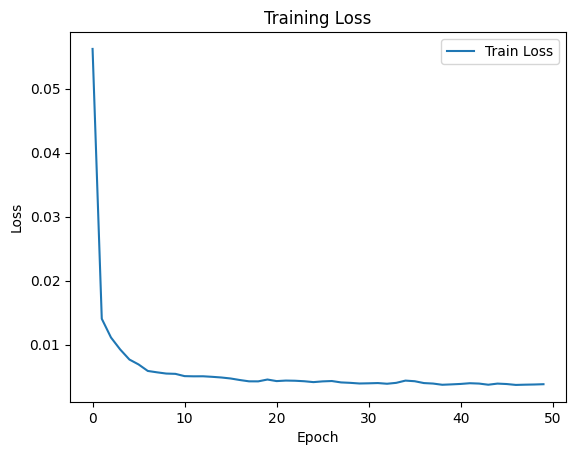

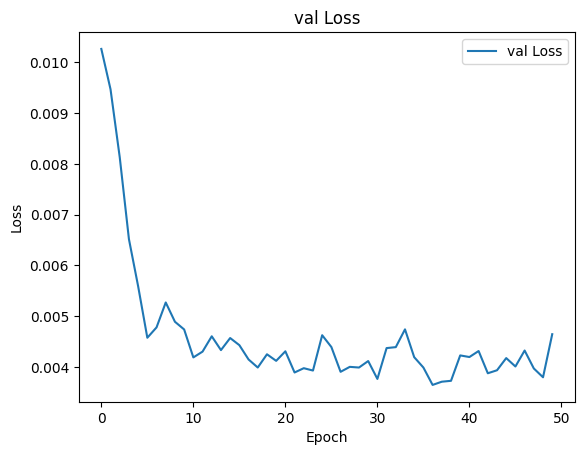

In [49]:
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_losses, label="val Loss")
plt.title("val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [50]:
# 3차원 데이터를 2차원으로 변환
test_predictions_reshaped = test_predictions.reshape(test_predictions.shape[0], -1)

# 역변환 적용
test_predictions_inverse = mny.inverse_transform(test_predictions_reshaped)

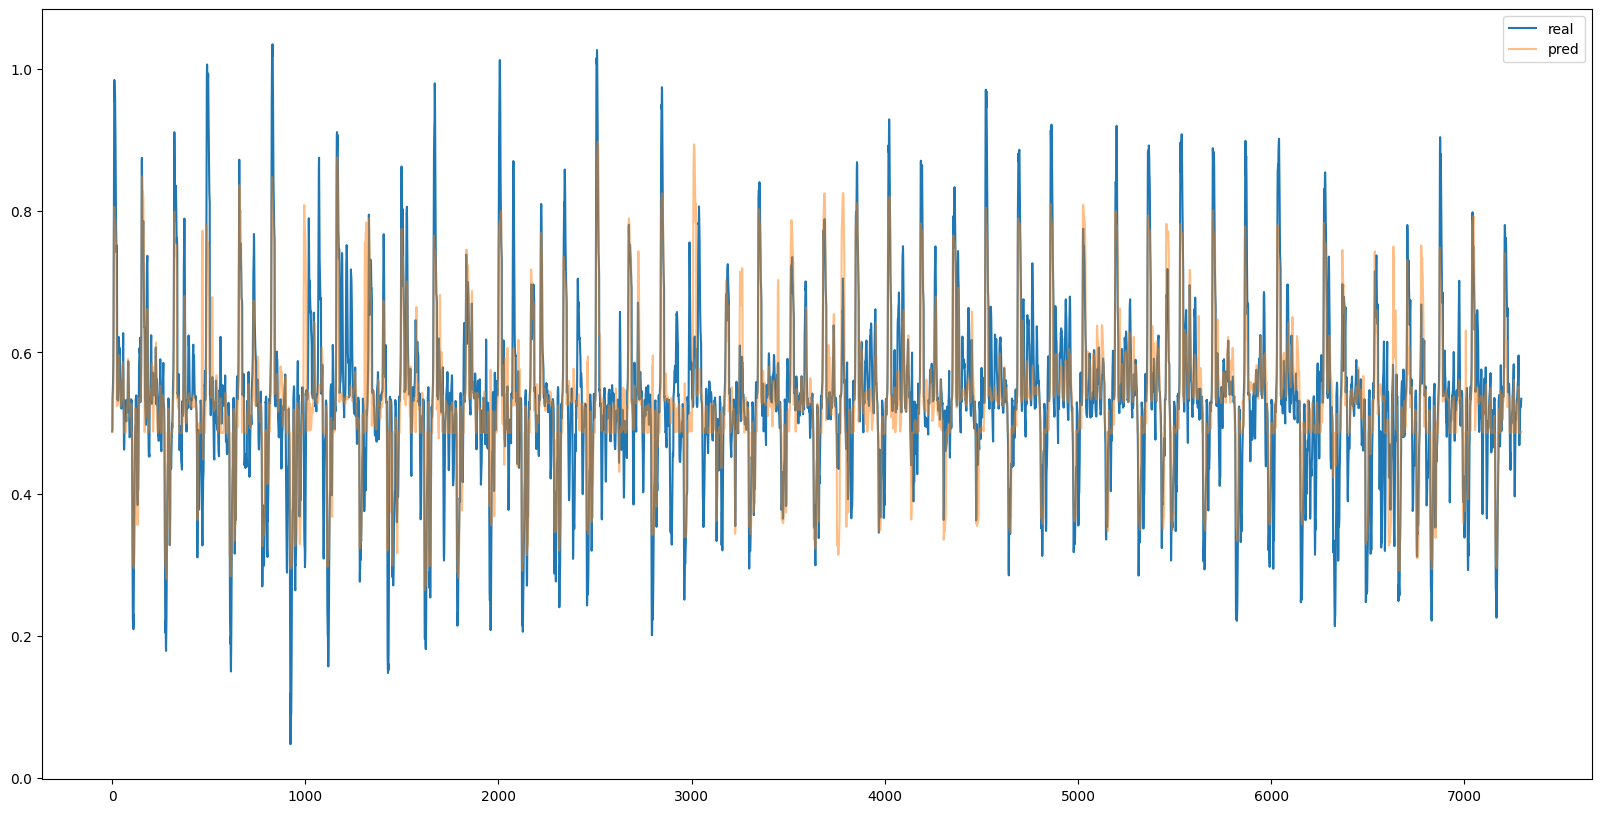

In [51]:
#  예측값 반정규화 실시
ssss1 = test_predictions_inverse.flatten()

plt.figure(figsize=(20,10))
plt.plot(test_y, label = "real")
plt.plot(test_predictions, label = "pred", alpha=0.5)
plt.legend()

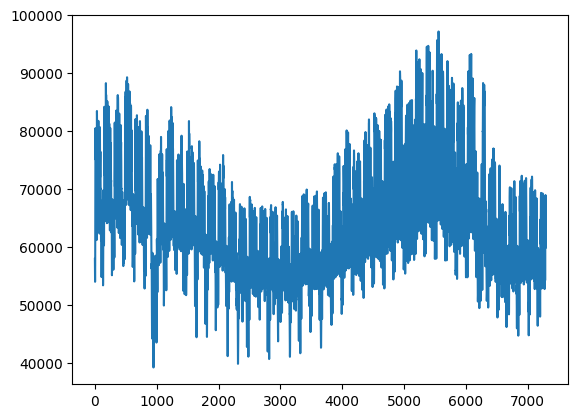

In [52]:
# real
plt.plot(test_data["power demand(MW)"].values[-7320+24:])

In [53]:
len(predictions["0"][train_length + val_length+24:].values)

7296

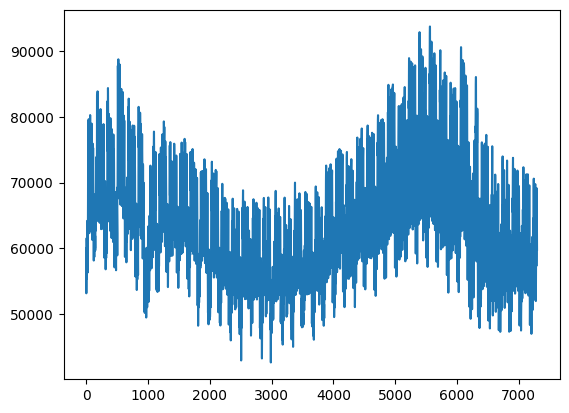

In [54]:
plt.plot(predictions["0"][train_length + val_length+24:].values)


r2_score : 0.8891712122621847
mean_squared_error : 3453.17485680748
mean_absolute_percentage_error:0.038011717191506464


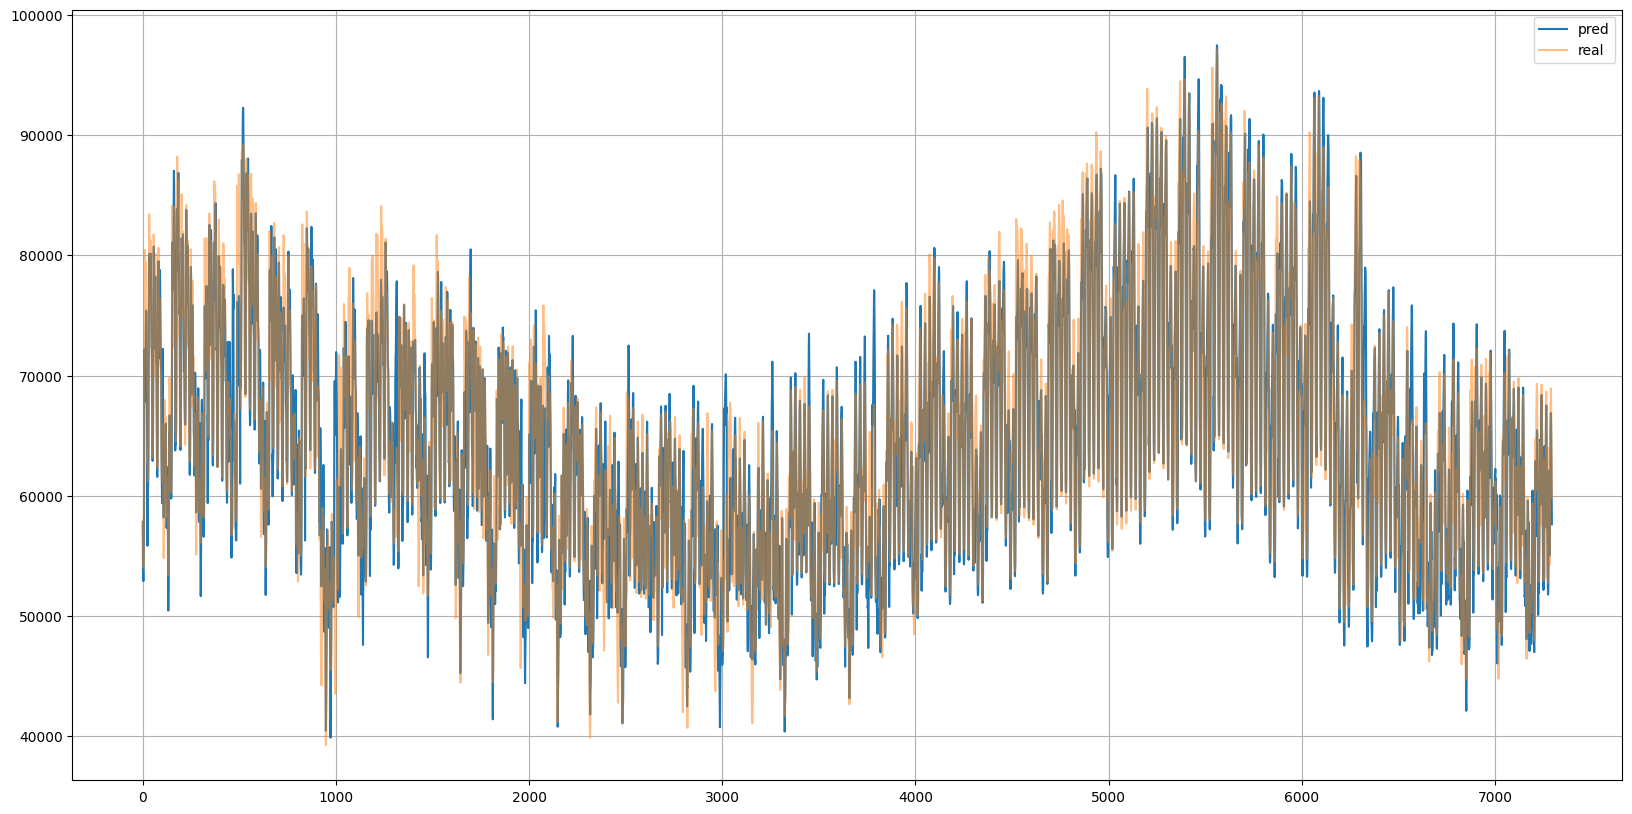

In [55]:
test_real = test_data["power demand(MW)"].values[-7320+24:]

pred_data = test_predictions_inverse.flatten()
sarimax_conv_lstm = pred_data + predictions["0"][train_length + val_length+24:].values

plt.figure(figsize=(20,10))
plt.plot(sarimax_conv_lstm, label = "pred")
plt.plot(test_real, label = "real", alpha =0.5)
plt.grid()
plt.legend()

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

print(f"r2_score : {r2_score(test_real, sarimax_conv_lstm)}")
print(f"mean_squared_error : {np.sqrt(mean_squared_error(test_real, sarimax_conv_lstm))}")
print(f"mean_absolute_percentage_error:{mean_absolute_percentage_error(test_real, sarimax_conv_lstm)}")

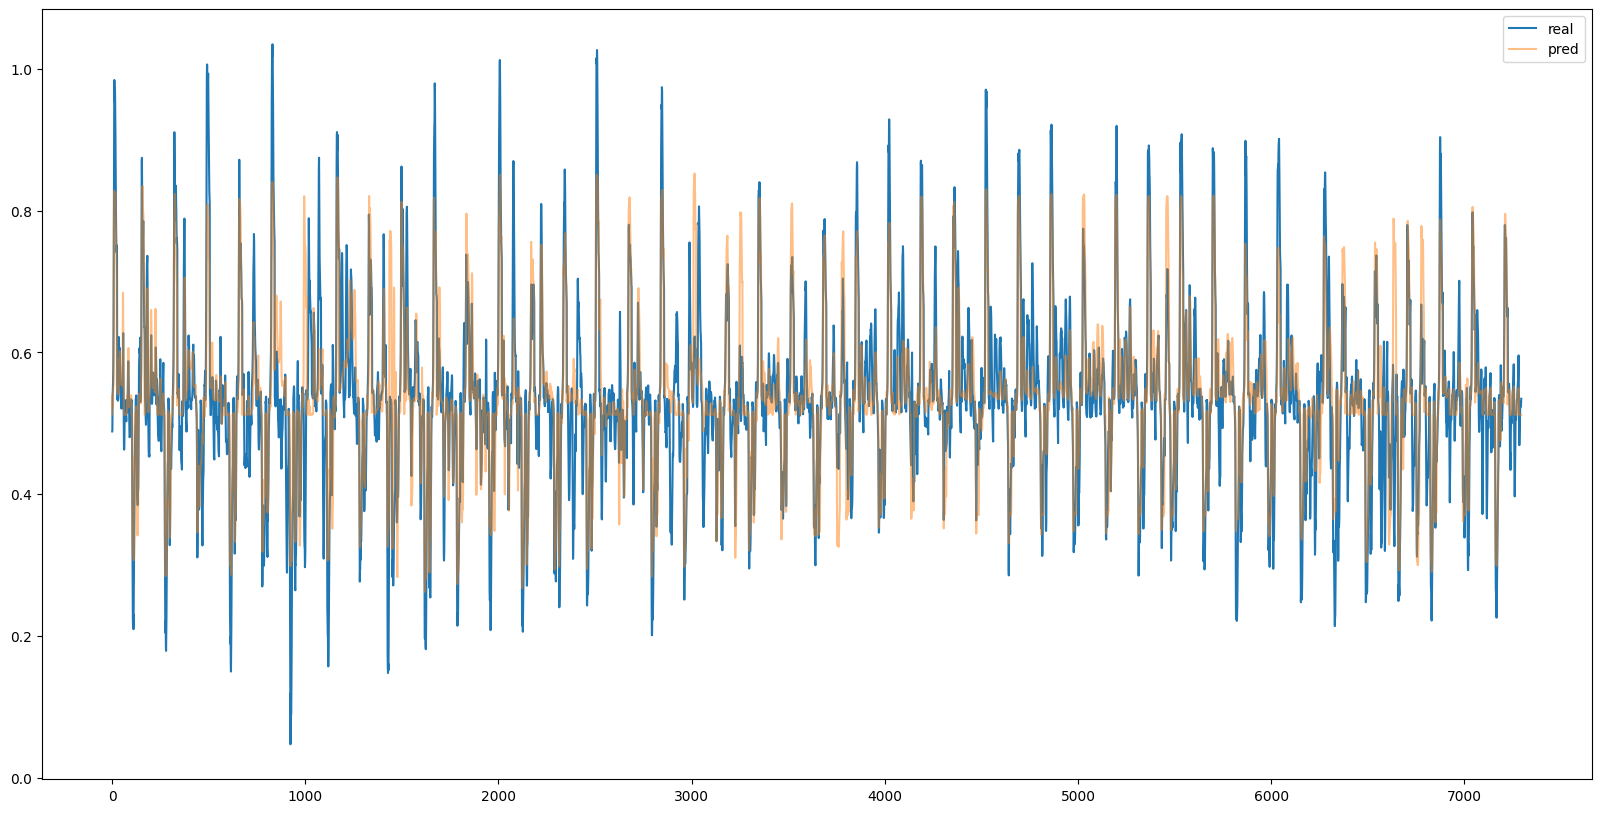

In [37]:
#  예측값 반정규화 실시
ssss1 = test_predictions_inverse.flatten()

plt.figure(figsize=(20,10))
plt.plot(test_y, label = "real")
plt.plot(test_predictions, label = "pred", alpha=0.5)
plt.legend()

In [ ]:
sarimax
r2_score : 0.6881738239454865
root_mean_squared_error : 5789.15447641252
mean_absolute_percentage_error:0.06051528460789004

sarimax-dbo-lstm
r2_score : 0.9986100582671962
root_mean_squared_error : 386.69187933968914
mean_absolute_percentage_error:0.005194897962689359

dbo-lstm
r2_score : 0.5153434637598708
root_mean_squared_error : 7224.436249624898
mean_absolute_percentage_error:0.08433445593202396

### SARIMAX-DBO-LSTM 결과
r2_score : 0.9961151795929882
mean_squared_error : 646.4757336314701
mean_absolute_percentage_error:0.0068506590850560545

In [70]:
# 평가 지표 확인방법
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

print(f"r2_score : {r2_score(test_real, sarimax_lstm)}")
print(f"mean_squared_error : {np.sqrt(mean_squared_error(test_real, sarimax_lstm))}")
print(f"mean_absolute_percentage_error:{mean_absolute_percentage_error(test_real, sarimax_lstm)}")

r2_score : 0.9958331462887345
mean_squared_error : 669.5312947169041
mean_absolute_percentage_error:0.007462830818914158


### LSTM 적용

In [152]:
train_data = df[df.index<="2024-01-01"]
test_data = df[df.index>"2024-01-01"]

# 표준화
mnx = MinMaxScaler()
mny = MinMaxScaler()

# "hm", "ta","weekday", "weekend",	"spring", "summer",	"autoum", "winter"
train_x = train_data[["hm", "ta","weekday", "weekend",	"spring", "summer",	"autoum", "winter"]]
train_y = train_data["power demand(MW)"]
test_x = test_data[["hm", "ta","weekday", "weekend", "spring", "summer",	"autoum", "winter"]]
test_y = test_data["power demand(MW)"]

# 표준화
train_scaled_x = mnx.fit_transform(train_x)
train_scaled_y = mny.fit_transform(train_y.values.reshape(-1,1))

test_scaled_x = mnx.transform(test_x)
test_scaled_y = mny.transform(test_y.values.reshape(-1,1))

In [154]:
def sliding_window(datax, datay, window_size):
    x = []
    y = []
    
    for i in range(len(datax) - window_size + 1):
        xx = datax[i:window_size + i]  # 윈도우 크기 만큼 입력 생성
        yy = datay[window_size + i - 1]  # 윈도우의 마지막 값을 출력으로 설정
        x.append(xx)
        y.append(yy)
    
    return np.array(x), np.array(y)

In [155]:
train_x, train_y = sliding_window(train_scaled_x, train_scaled_y, window_size=24)
test_x, test_y = sliding_window(test_scaled_x, test_scaled_y, window_size=24)

# val 생성
from sklearn.model_selection import train_test_split
train_x, val_x,train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False)

# 형태 확인
print(f"train_x:{train_x.shape}")
print(f"train_y:{train_y.shape}")
print(f"test_x:{test_x.shape}")
print(f"test_y:{test_y.shape}")
print(f"val_x:{val_x.shape}")
print(f"val_y:{val_y.shape}")

train_x:(35041, 24, 8)
train_y:(35041, 1)
test_x:(7296, 24, 8)
test_y:(7296, 1)
val_x:(8761, 24, 8)
val_y:(8761, 1)


In [186]:
def sliding_window_scaled(train_x, train_y, test_x, test_y, window_size=24):
    """
    슬라이딩 윈도우 방식으로 데이터를 나누는 함수
    ex:
    0:24[input] -> 24:48[output]
    """
    input_train, target_train = [], []
    input_test, target_test = [], []

    # Train 데이터 슬라이딩 윈도우
    for idx in range(len(train_x) - 2 * window_size + 1):
        if idx % window_size == 0:  # 윈도우 크기 간격
            print(f"Train Sliding Window: {idx} ~ {idx + window_size}")
            x = train_x[idx : idx + window_size]  # 0:24
            y = train_y[idx + window_size : idx + 2 * window_size]  # 24:48
            input_train.append(x)
            target_train.append(y)

    # Test 데이터 슬라이딩 윈도우
    for idx in range(len(test_x) - 2 * window_size + 1):
        if idx % window_size == 0:  # 윈도우 크기 간격
            print(f"Test Sliding Window: {idx} ~ {idx + window_size}")
            x1 = test_x[idx : idx + window_size]  # 0:24
            y1 = test_y[idx + window_size : idx + 2 * window_size]  # 24:48
            input_test.append(x1)
            target_test.append(y1)

    # 결과 확인용 출력
    print(f"Total Train Samples: {len(input_train)}, Total Test Samples: {len(input_test)}")
    return (
        np.array(input_train),
        np.array(target_train),
        np.array(input_test),
        np.array(target_test),
    )

In [154]:
train_x, train_y, test_x, test_y = sliding_window_scaled(
    scaled_train, scaled_train, scaled_test, scaled_test)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False)

Train Sliding Window: 0 ~ 24
Train Sliding Window: 24 ~ 48
Train Sliding Window: 48 ~ 72
Train Sliding Window: 72 ~ 96
Train Sliding Window: 96 ~ 120
Train Sliding Window: 120 ~ 144
Train Sliding Window: 144 ~ 168
Train Sliding Window: 168 ~ 192
Train Sliding Window: 192 ~ 216
Train Sliding Window: 216 ~ 240
Train Sliding Window: 240 ~ 264
Train Sliding Window: 264 ~ 288
Train Sliding Window: 288 ~ 312
Train Sliding Window: 312 ~ 336
Train Sliding Window: 336 ~ 360
Train Sliding Window: 360 ~ 384
Train Sliding Window: 384 ~ 408
Train Sliding Window: 408 ~ 432
Train Sliding Window: 432 ~ 456
Train Sliding Window: 456 ~ 480
Train Sliding Window: 480 ~ 504
Train Sliding Window: 504 ~ 528
Train Sliding Window: 528 ~ 552
Train Sliding Window: 552 ~ 576
Train Sliding Window: 576 ~ 600
Train Sliding Window: 600 ~ 624
Train Sliding Window: 624 ~ 648
Train Sliding Window: 648 ~ 672
Train Sliding Window: 672 ~ 696
Train Sliding Window: 696 ~ 720
Train Sliding Window: 720 ~ 744
Train Sliding Wind

In [30]:
# 형태 확인
print(f"train_x:{train_x.shape}")
print(f"train_y:{train_y.shape}")
print(f"test_x:{test_x.shape}")
print(f"test_y:{test_y.shape}")
print(f"val_x:{val_x.shape}")
print(f"val_y:{val_y.shape}")

train_x:(35041, 24, 8)
train_y:(35041, 1)
test_x:(7296, 24, 8)
test_y:(7296, 1)
val_x:(8761, 24, 8)
val_y:(8761, 1)


In [156]:
# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, lstm_layers, dense_layers, units, dense_units, lstm_dropout_rate, dense_dropout_rate, input_features):
        super(LSTM, self).__init__()
        # LSTM 레이어
        self.lstm = nn.LSTM(input_size=input_features, hidden_size=units, num_layers=lstm_layers, dropout=lstm_dropout_rate, batch_first=True)
        # Dense 레이어
        self.dense_layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(units if i == 0 else dense_units, dense_units),
                nn.ReLU(),
                nn.Dropout(dense_dropout_rate)
            ) for i in range(dense_layers)]
        )
        # 출력 레이어
        self.output_layer = nn.Linear(dense_units if dense_layers > 0 else units, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM 적용
        x = x[:, -1, :]  # 마지막 타임스텝 출력 사용
        for layer in self.dense_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# DataLoader 생성 함수
def create_dataloader(X, Y, batch_size):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 64)
    return dataloader

# Fitness 함수
def fitness_function(params, X_train, Y_train, X_val, Y_val, device):
    lstm_layers, dense_layers, units, dense_units, learning_rate, lstm_dropout_rate, dense_dropout_rate, batch_size = (
        int(params[0]), int(params[1]), int(params[2]), int(params[3]), params[4], params[5], params[6], int(params[7])
    )

    # LSTM 모델 생성
    input_features = X_train.shape[2]
    model = LSTM(
        lstm_layers=lstm_layers,
        dense_layers=dense_layers,
        units=units,
        dense_units=dense_units,
        lstm_dropout_rate=lstm_dropout_rate,
        dense_dropout_rate=dense_dropout_rate,
        input_features=input_features
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # DataLoader 생성
    train_loader = create_dataloader(X_train, Y_train, batch_size)

    # 모델 학습
    model.train()
    for epoch in range(50):  # 간단히 50 Epoch로 설정
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_Y)
            loss.backward()
            optimizer.step()

    # 검증 손실 계산
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).to(device)
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, Y_val_tensor).item()

    return val_loss

# DBO 알고리즘 구현
def DBO_LSTM_with_obstacle(X_train, Y_train, X_val, Y_val, num_beetles=5, max_iter=10, device='cpu'):
    # Bounds as defined in the paper
    bounds = [
        np.array([1, 2, 10, 100, 0.0001, 0.1, 0.1, 16]),  # lower bounds
        np.array([2, 3, 100, 300, 0.01, 0.5, 0.5, 256])  # upper bounds
    ]
    
    # Initialize positions
    positions = np.random.uniform(bounds[0], bounds[1], (num_beetles, len(bounds[0])))
    previous_positions = positions.copy()
    
    # Initialize best and worst positions
    fitness_values = [fitness_function(pos, X_train, Y_train, X_val, Y_val, device) 
                     for pos in positions]
    best_position = positions[np.argmin(fitness_values)]
    worst_position = positions[np.argmax(fitness_values)]
    best_fitness = np.min(fitness_values)

    # Constants from the paper
    k = 0.1  # deflection coefficient
    b = 0.3  # constant value
    S = 0.5  # thief behavior constant
    
    for t in range(max_iter):
        R = 1 - t / max_iter  # Reduction ratio
        
        for i in range(num_beetles):
            # Probability for obstacle occurrence (20%)
            obstacle = np.random.choice([True, False], p=[0.2, 0.8])
            
            if obstacle:
                # Dancing behavior (Equation 2)
                theta = np.random.uniform(0, np.pi)
                positions[i] += np.tan(theta) * np.abs(positions[i] - previous_positions[i])
            else:
                # Ball rolling behavior (Equation 1)
                delta_x = np.abs(positions[i] - worst_position)  # Using worst position as per paper
                alpha = np.random.choice([-1, 1])
                positions[i] += alpha * k * (positions[i] - previous_positions[i]) + b * delta_x

            # Calculate boundaries for spawning area (Equation 3)
            Lb_star = np.maximum(best_position * (1 - R), bounds[0])
            Ub_star = np.minimum(best_position * (1 + R), bounds[1])
            
            # Egg laying behavior (Equation 4)
            b1 = np.random.uniform(0, 1, size=positions[i].shape)
            b2 = np.random.uniform(0, 1, size=positions[i].shape)
            egg_position = best_position + b1 * (positions[i] - Lb_star) + b2 * (positions[i] - Ub_star)
            
            # Calculate boundaries for foraging area (Equation 5)
            Lbb = np.maximum(best_position * (1 - R), bounds[0])
            Ubb = np.minimum(best_position * (1 + R), bounds[1])
            
            # Small beetle foraging behavior (Equation 6)
            C1 = np.random.normal(0, 1, size=positions[i].shape)
            C2 = np.random.uniform(0, 1, size=positions[i].shape)
            foraging_position = positions[i] + C1 * (positions[i] - Lbb) + C2 * (positions[i] - Ubb)
            
            # Thief behavior (Equation 7)
            g = np.random.normal(0, 1, size=positions[i].shape)
            thief_position = (best_position + 
                            S * g * (np.abs(positions[i] - best_position) + 
                                   np.abs(positions[i] - best_position)))
            
            # Combine positions
            positions[i] = (egg_position + thief_position) / 2
            
            # Ensure bounds
            positions[i] = np.clip(positions[i], bounds[0], bounds[1])

        # Store previous positions
        previous_positions = positions.copy()
        
        # Evaluate fitness
        args = [(positions[i], X_train, Y_train, X_val, Y_val, device) 
                for i in range(num_beetles)]
        if device == 'cuda':
            fitness_values = [fitness_function(*arg) for arg in args]
        else:
            with Pool(processes=cpu_count()) as pool:
                fitness_values = pool.map(lambda arg: fitness_function(*arg), args)
        
        # Update best and worst positions
        min_idx = np.argmin(fitness_values)
        max_idx = np.argmax(fitness_values)
        if fitness_values[min_idx] < best_fitness:
            best_fitness = fitness_values[min_idx]
            best_position = positions[min_idx]
        worst_position = positions[max_idx]
        
        print(f"Iteration {t + 1}, Best Fitness: {best_fitness:.4f}, Best Position: {best_position}")
        
    return best_position

# 모델 학습 함수
def train_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, params, device):
    lstm_layers, dense_layers, units, dense_units, learning_rate, lstm_dropout_rate, dense_dropout_rate, batch_size = params
    input_features = X_train.shape[2]

    model = LSTM(
        lstm_layers=int(lstm_layers),
        dense_layers=int(dense_layers),
        units=int(units),
        dense_units=int(dense_units),
        lstm_dropout_rate=lstm_dropout_rate,
        dense_dropout_rate=dense_dropout_rate,
        input_features=input_features
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # DataLoader 생성
    train_loader = create_dataloader(X_train, Y_train, int(batch_size))
    val_loader = create_dataloader(X_val, Y_val, int(batch_size))

    model.train()
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(50), desc="Training Progress"):
        epoch_train_loss = 0
        model.train()
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X)
            train_loss = criterion(predictions, batch_Y)
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()
        
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss 계산
        epoch_val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch_X, batch_Y in val_loader:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                predictions = model(batch_X)
                val_loss = criterion(predictions, batch_Y)
                epoch_val_loss += val_loss.item()
        val_losses.append(epoch_val_loss / len(val_loader))

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/50], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    print("Model training complete.")

    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        test_predictions = model(X_test_tensor).cpu().numpy()

    return model, test_predictions, train_losses, val_losses


In [40]:
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    '''
    bounds = [
        np.array([1, 2, 10, 100, 0.0001, 0.1, 0.1, 24]),  # lower bounds
        np.array([2, 4, 100, 300, 0.01, 0.5, 0.5, 128])  # upper bounds
    ]
    '''
    # DBO 실행
    best_params = DBO_LSTM_with_obstacle(train_x, train_y, val_x, val_y, device=device) # 이 부분이 val data로 찢어서 처리해야 함.
    print("Best Parameters Found:", best_params)
    print("=============================================================")

    model, test_predictions, train_losses = train_model(train_x, train_y, test_x, test_y, best_params, device)

KeyboardInterrupt: 

In [157]:
# [1.00000000e+00 3.00000000e+00 3.07407899e+01 3.00000000e+02 1.00000000e-02 5.00000000e-01 2.42552371e-01 1.59608961e+02]
best_params = [1.00000000e+00, 2.72349373e+00, 1.00000000e+02, 1.81519094e+02,
 3.27098064e-03, 5.00000000e-01, 1.00000000e-01, 4.61040158e+01]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model, test_predictions, train_losses, val_losses = train_model(
    X_train=train_x, 
    Y_train=train_y, 
    X_val = val_x,
    Y_val = val_y, 
    X_test=test_x, 
    Y_test=test_y, 
    params=best_params, 
    device=device
)

# 결과 출력
print("Model training complete with best parameters!")

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training Progress:  20%|██        | 10/50 [01:23<05:33,  8.33s/it]

Epoch [10/50], Train Loss: 0.0035, Val Loss: 0.0042


Training Progress:  40%|████      | 20/50 [02:42<03:54,  7.83s/it]

Epoch [20/50], Train Loss: 0.0029, Val Loss: 0.0043


Training Progress:  60%|██████    | 30/50 [04:07<02:46,  8.35s/it]

Epoch [30/50], Train Loss: 0.0027, Val Loss: 0.0041


Training Progress:  80%|████████  | 40/50 [05:33<01:23,  8.36s/it]

Epoch [40/50], Train Loss: 0.0023, Val Loss: 0.0044


Training Progress: 100%|██████████| 50/50 [07:02<00:00,  8.45s/it]

Epoch [50/50], Train Loss: 0.0021, Val Loss: 0.0041
Model training complete.
Model training complete with best parameters!


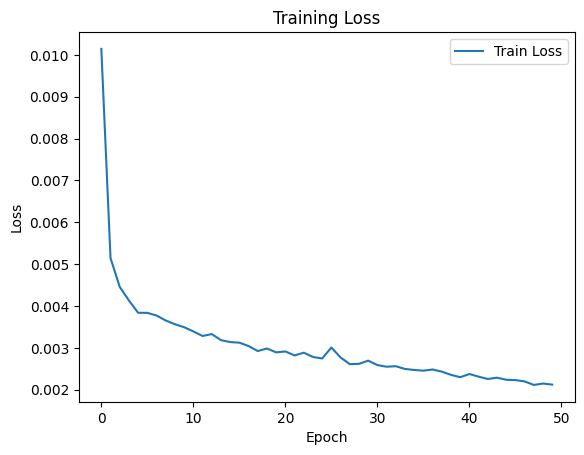

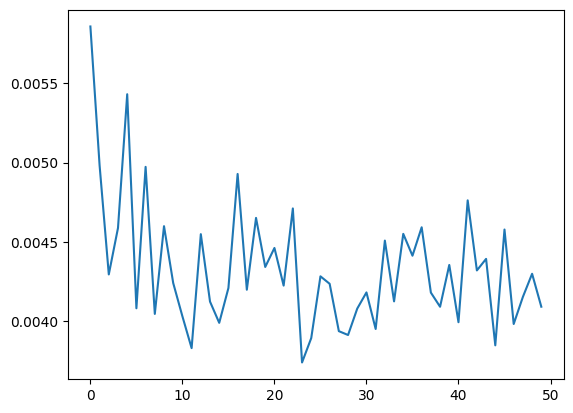

In [158]:
plt.plot(train_losses, label="Train Loss")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_losses, label="val Loss")


In [159]:
# 역변환 적용
test_predictions = test_predictions.reshape(-1, test_predictions.shape[-1])
test_predictions_inverse = mny.inverse_transform(test_predictions)

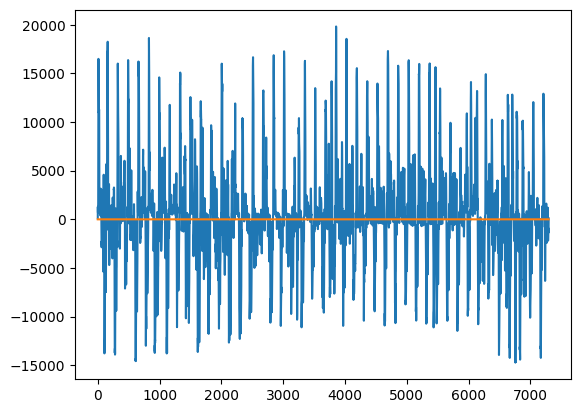

In [ ]:
plt.plot(test_predictions_inverse.flatten())
plt.plot(test_y)


In [ ]:
plt.plot(mny.inverse_tramsform(test_y))

AttributeError: 'MinMaxScaler' object has no attribute 'inverse_tramsform'

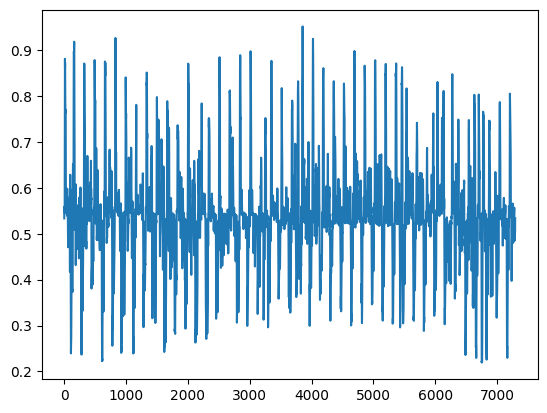

In [69]:
plt.plot(test_predictions)
plt.plot()


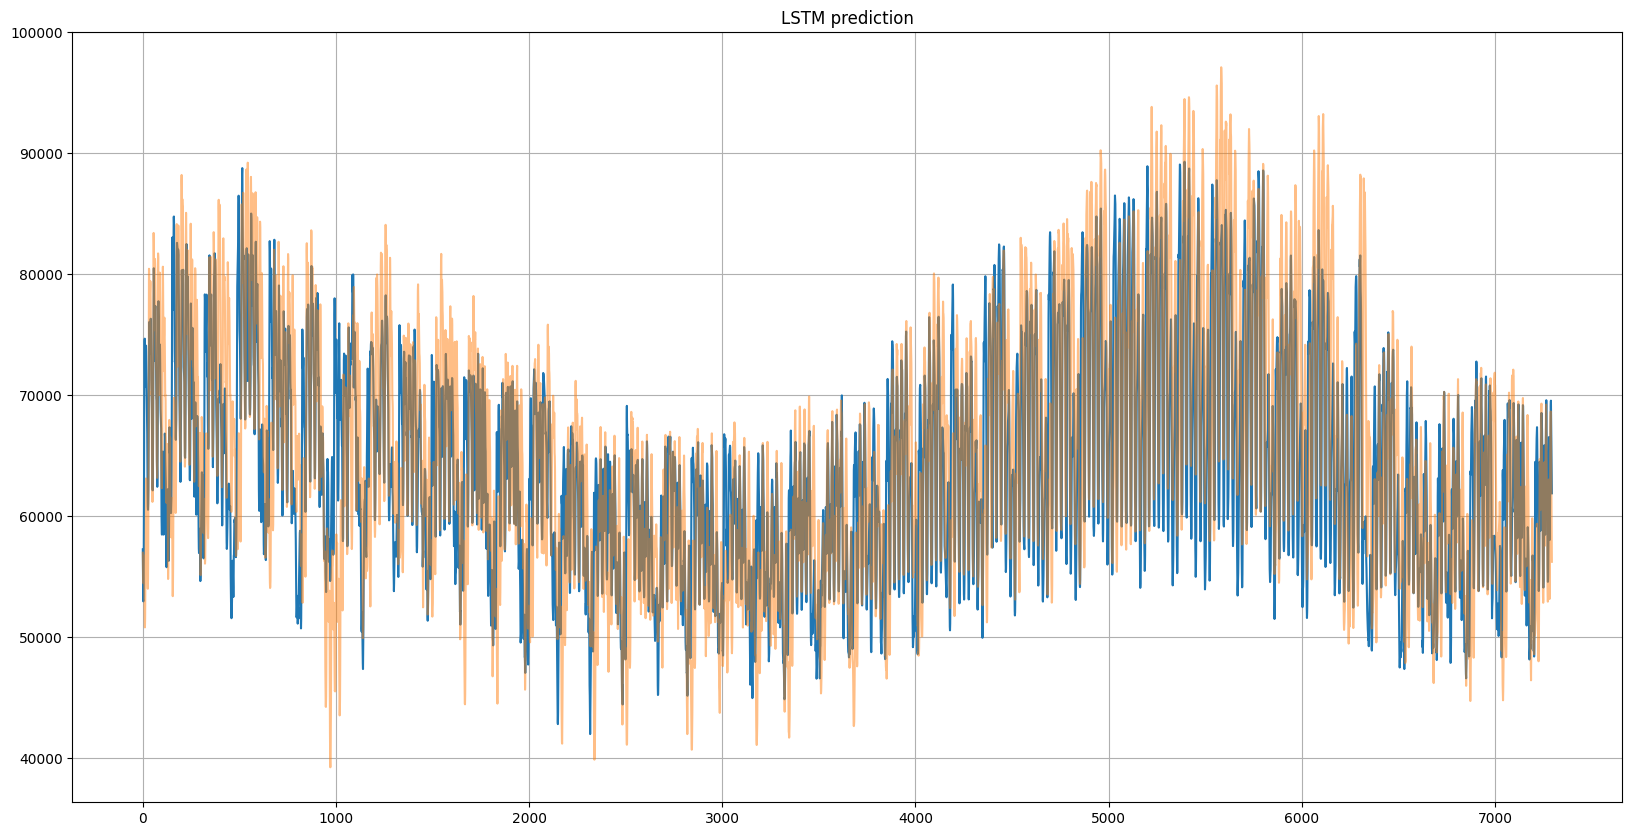

In [162]:
test_predictions_inverse1 = test_predictions_inverse.flatten()
test_real = test_data["power demand(MW)"].values[:-23]

plt.figure(figsize=(20,10))
plt.plot(test_predictions_inverse1.flatten())
plt.plot(test_real, alpha=0.5)
plt.title("LSTM prediction") 
plt.grid()

In [234]:
len(test_predictions_inverse.flatten()) # 7296
len(test_real) # 7319

7319

In [236]:
# 평가 지표 확인방법
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

print(f"r2_score : {r2_score(test_real[:-23], test_predictions_inverse1)}")
print(f"mean_squared_error : {np.sqrt(mean_squared_error(test_real[:-23], test_predictions_inverse1))}")
print(f"mean_absolute_percentage_error:{mean_absolute_percentage_error(test_real[:-23], test_predictions_inverse1)}")

r2_score : 0.5153434637598708
mean_squared_error : 7224.436249624898
mean_absolute_percentage_error:0.08433445593202396


sarimax
r2_score : 0.6881738239454865
root_mean_squared_error : 5789.15447641252
mean_absolute_percentage_error:0.06051528460789004

sarimax-dbo-lstm
r2_score : 0.9986100582671962
root_mean_squared_error : 386.69187933968914
mean_absolute_percentage_error:0.005194897962689359

dbo-lstm
r2_score : 0.5153434637598708
root_mean_squared_error : 7224.436249624898
mean_absolute_percentage_error:0.08433445593202396